In [11]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [12]:
#download stock data
tickers = ['AAPL', 'TSLA','MSFT']
data = yf.download(tickers, start='2021-01-01', end='2024-09-15')['Adj Close']
returns = data.pct_change().dropna()  # Daily returns

[*********************100%***********************]  3 of 3 completed


In [13]:
#calculate annual returns and covariance matrix
mean_returns=returns.mean()*252 #annual returns
cov_matrix=returns.cov()*252 #annual covariance

In [14]:
#define portfolio performance fxn
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(weights * mean_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, risk

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    p_returns, p_risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_returns - risk_free_rate) / p_risk  # Negate for minimization

In [15]:
#set constraints & bounds 
num_assets = len(tickers)
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = tuple((0, 1) for _ in range(num_assets))
initial_weights = num_assets * [1 / num_assets]  # Equal distribution



In [16]:
#optimize portfolio
optimal_result = minimize(negative_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix),
method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = optimal_result.x

In [17]:
#optimize portfolio results
optimal_returns, optimal_risk = portfolio_performance(optimal_weights, mean_returns, cov_matrix)
print("Optimal Weights:", optimal_weights)
print("Expected Annual Return:", optimal_returns)
print("Expected Annual Risk:", optimal_risk)

Optimal Weights: [1.98781691e-01 8.01218309e-01 2.49366500e-17]
Expected Annual Return: 0.22096177524699562
Expected Annual Risk: 0.2523271970705709


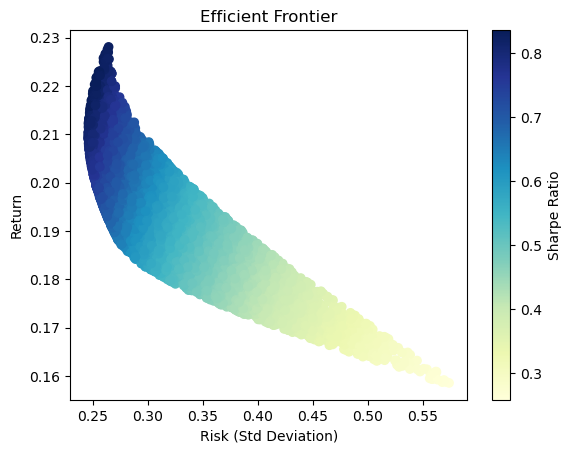

In [22]:
#visualize the efficient frontier
def plot_efficient_frontier(mean_returns, cov_matrix, num_portfolios=10000):
    results = np.zeros((3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns, risk = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0, i] = risk
        results[1, i] = returns
        results[2, i] = (returns - 0.01) / risk  # Sharpe ratio

    plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='YlGnBu', marker='o')
    plt.title('Efficient Frontier')
    plt.xlabel('Risk (Std Deviation)')
    plt.ylabel('Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

plot_efficient_frontier(mean_returns, cov_matrix)